In [19]:
import numpy as np
import matplotlib.pyplot as plt

#FFT engines
from numpy.fft import rfftfreq,irfft
#Interpolation
from scipy import interpolate
#Units 
from astropy.units import s,Hz,kHz


# ノイズのパワースペクトルから、実際のnoise todを生成する。
参考　(https://gist.github.com/apetri/3a171080e9eaa987d4cb)

# まずはパワースペクトルを定義。

/tmp/ipykernel_416/3761398419.py:23: RuntimeWarning: divide by zero encountered in power
  PSD = np.clip(PSD_ref * (f / f_ref)**(-alpha), -1, clip_value)


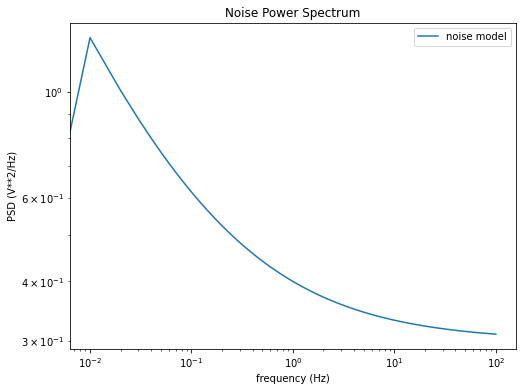

In [77]:
N = 4096
fs = 20
T = int(N-1)/fs
t = np.arange(N)/fs

# define noise power spectrum
def white_noise(f, PSD_value):
    """
    f: frequency
    PSD: power specrum density in units of (V**2)/Hz
    """
    PSD = np.ones_like(f) * PSD_value
    PSD[0] = 0
    return PSD

def pink_noise(f, PSD_ref, f_ref, alpha, clip_value=1e5):
    """
    f: frequency
    f_ref: reference frequency
    PSD_ref: power specrum density at reference frequency in units of (V**2)/Hz
    alpha: power law index
    """
    PSD = np.clip(PSD_ref * (f / f_ref)**(-alpha), -1, clip_value)
    PSD[0] = 0
    return PSD

f_PSD = np.arange(0, 100.001, 0.01)

white_noise_power = 0.3 # V**2/Hz
PSD_white_noise_model = white_noise(f_PSD, noise_power)

pink_noise_freq = 1 # Hz
pink_noise_power = 0.1 # V**2/Hz at 1 Hz
alpha = 0.5

PSD_pink_noise_model = pink_noise(f_PSD, pink_noise_power, pink_noise_freq, alpha) 
PSD_noise_model = PSD_white_noise_model + PSD_pink_noise_model

# plot noise power spectrum
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(f_PSD, PSD_noise_model, label='noise model')

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('PSD (V**2/Hz)')
ax.set_title('Noise Power Spectrum')
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend()


# 定義したPSDからフーリエ係数を定義。
PSDの計算は前節を参照。

In [80]:
def calc_ft_coef(f, f_PSD, PSD, seed=1234):
    """
    f: frequency
    f_PSD: frequency of noise power spectrum
    PSD: noise power spectrum
    """
    # interpolate noise power spectrum
    PSD_interp = interpolate.interp1d(f_PSD, PSD, kind='linear')(f)

    # set seed
    np.random.seed(seed)
    
    # calculate fourier coefficients
    ft_amplitude = np.sqrt(PSD_interp * T * fs**2 / 2) #正の周波数のみなのでPSDを半分にして、amplicudeを計算している。
    ft_phase = np.random.uniform(0, 2*np.pi, size=f.shape)
    ft_coef = ft_amplitude * np.exp(1.0j*ft_phase)
    
    return ft_coef

# plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


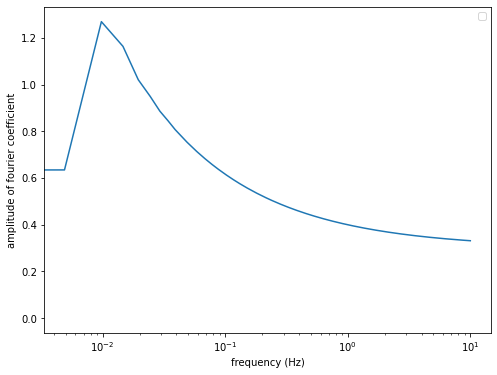

In [82]:
seed = np.random.randint(0, 10000)

f = rfftfreq(N, d=1/fs)
ft_coef = calc_ft_coef(f, f_PSD, PSD_noise_model, seed=seed)
ft_coef_amp = np.abs(ft_coef)
ft_coef_PSD = 2 * ft_coef_amp**2 / (T * fs**2)

fig, ax = plt.subplots(1,1, figsize=(8,6), label='PSD calculated by Fourier coefficients')
ax.plot(f, ft_coef_PSD)

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('amplitude of fourier coefficient')
ax.set_xscale('log')
ax.legend()

# Convert to TOD

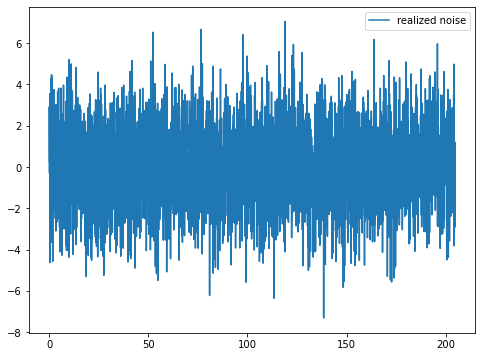

In [84]:
realized_noise = irfft(ft_coef)
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(t, realized_noise, label='realized noise')
ax.legend()

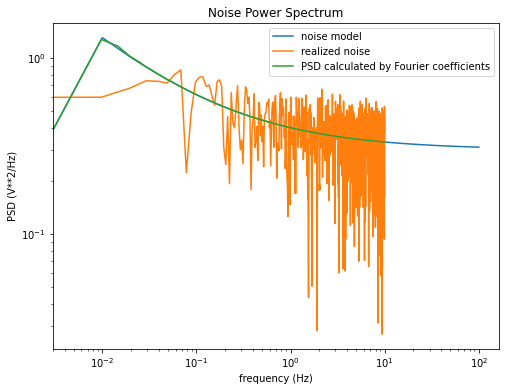

In [85]:
from scipy import signal

f_recover, PSD_recover = signal.welch(realized_noise, fs, nperseg=2048)

# plot noise power spectrum
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(f_PSD, PSD_noise_model, label='noise model')
ax.plot(f_recover, PSD_recover , label='realized noise')
ax.plot(f, ft_coef_PSD, label='PSD calculated by Fourier coefficients')

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('PSD (V**2/Hz)')
ax.set_title('Noise Power Spectrum')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()